# Neural Network From Scratch
## classification demo

In [1]:
from andreiNet.neural_net import NeuralNetwork
from andreiNet.utils import norm_data, one_hot_encode
from andreiNet.metrics import accuracy

In [2]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time
import numpy as np

In [3]:
# Load Iris Dataset
iris = datasets.load_iris()
X = iris.data  
y = iris.target

# We will also split the dataset into training and testing so we can evaluate the kNN classifier
X_trn, X_test, y_trn, y_test = train_test_split(X, 
                                                  y, 
                                                  test_size=0.80, 
                                                  random_state=0,
                                                  stratify=y)

print("X_trn.shape = {}, X_test.shape = {}".format(X_trn.shape, X_test.shape))
X_trn_norm, (trn_mean, trn_std) = norm_data(X_trn)
X_test_norm = (X_test - trn_mean) / trn_std

X_trn.shape = (30, 4), X_test.shape = (120, 4)


In [4]:
# Set parameters
activation = 'ReLU'
batch_size = 50
random_state = 0
lr = 0.001
n_epochs = 10000
loss = 'cross_entropy'
metrics = ['accuracy']
weight_init = 'he_norm'
hidden_layers = (50, 60, 50)

# Initialize model
start_time = time.time()
nn = NeuralNetwork(hidden=hidden_layers, 
                   init_weights=weight_init,
                   loss=loss,
                   activation=activation,
                   shuffle=True,
                   random_state=random_state,
                   metrics=metrics,
                   verbose=False
                   )

# Train model
nn.train(X_trn_norm, y_trn, 
         n_epochs=n_epochs,
         batch_size=batch_size, 
         early_stop=None, # ('accuracy', 500),
         lr=lr, 
         val_data=(X_test_norm, y_test),
         save_best=True)

# Run Inference
y_pred_trn = nn.predict(X_trn_norm).argmax(axis=1)
y_pred_test = nn.predict(X_test_norm).argmax(axis=1)

delta_1 = time.time() - start_time
print("--- %s seconds ---" % (delta_1))
print('trn acc', accuracy(y_pred_trn, y_trn))
print('test acc', accuracy(y_pred_test, y_test))

epoch 10000: final trn loss = 0.0421946740950931 trn metrics {'accuracy': 1.0, 'cross_entropy': 0.0421946740950931}
val metrics {'accuracy': 0.9083333333333333, 'cross_entropy': 0.2372676706524643}
setting best model from epoch 8000
--- 23.608565092086792 seconds ---
trn acc 1.0
test acc 0.9083333333333333


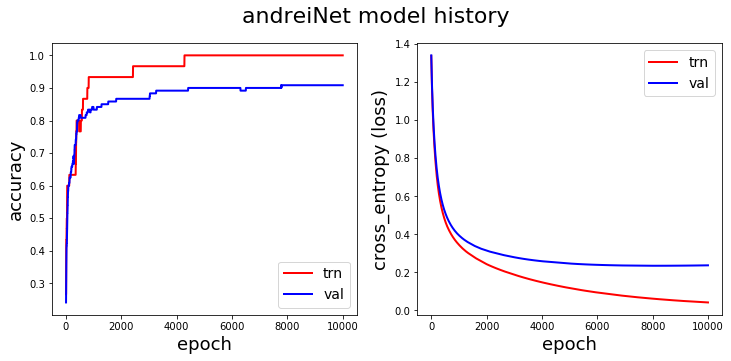

In [5]:
# Plot neural network history
loss = 'cross_entropy'
fig_size = (12, 5)
x_axis = np.arange(len(nn.trn_metric_hist[loss]))
metrics = nn.trn_metric_hist.keys()
fig, axs = plt.subplots(1, 2, figsize=fig_size)

for i, metric in enumerate(metrics):
    axs[i].plot(x_axis, nn.trn_metric_hist[metric], c='r', linewidth=2, label='trn')
    axs[i].plot(x_axis, nn.val_metric_hist[metric], c='b', linewidth=2, label='val')
    axs[i].set_xlabel('epoch', fontsize=18)
    axs[i].set_ylabel(metric, fontsize=18)
    if metric == loss:
        axs[i].set_ylabel(metric+' (loss)', 
                          fontsize=18)
    axs[i].legend(prop={'size': 14})
    
plt.suptitle('andreiNet model history', fontsize=22)
plt.show()

In [ ]:
# Train Keras model
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation
from keras.optimizers import SGD
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)

np.random.seed(random_state)
start_time = time.time()

model = Sequential()

for l, hidden in enumerate(hidden_layers):
    output_shape = hidden
    if l==0:
        input_shape = X_trn_norm.shape[1]
    else:
        input_shape = hidden_layers[l-1]
    model.add(Dense(output_shape, activation=activation.lower(), 
                input_dim=input_shape, 
                kernel_initializer='he_normal'))
    
model.add(Dense(3, activation='softmax',))

sgd = SGD(lr=lr, decay=0.0, momentum=0.00, nesterov=False)

model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

keras_hist = model.fit(X_trn_norm, one_hot_encode(y_trn, 3),
                       epochs=n_epochs,
                       validation_data=(X_test_norm, one_hot_encode(y_test, 3)),
                       batch_size=batch_size,
                       verbose=0)
y_pred_trn = model.predict(X_trn_norm).argmax(axis=1)
y_pred_test = model.predict(X_test_norm).argmax(axis=1)
delta_2 = time.time() - start_time
print("--- %s seconds ---" % (delta_2))
print('trn acc', accuracy(y_pred_trn, y_trn))
print('test acc', accuracy(y_pred_test, y_test))

Using TensorFlow backend.


In [ ]:
# Keras training history
fig_size = (12, 5)
x_axis = np.arange(n_epochs)
fig, axs = plt.subplots(1, 2, figsize=fig_size)

axs[0].plot(x_axis, keras_hist.history['acc'], c='r', linewidth=2, label='trn')
axs[0].plot(x_axis, keras_hist.history['val_acc'], c='b', linewidth=2, label='val')
axs[0].set_xlabel('epoch', fontsize=18)
axs[0].set_ylabel('accuracy', fontsize=18)
axs[0].legend(prop={'size': 14})

axs[1].plot(x_axis, keras_hist.history['loss'], c='r', linewidth=2, label='trn')
axs[1].plot(x_axis, keras_hist.history['val_loss'], c='b', linewidth=2, label='val')
axs[1].set_xlabel('epoch', fontsize=18)
axs[1].set_ylabel('categorical_crossentropy', fontsize=18)
axs[1].legend(prop={'size': 14})

plt.suptitle('Keras model history', fontsize=22)
plt.show()

In [ ]:
# compare training time
plt.figure(figsize=(6, 6))
trn_times = [delta_1, delta_2]
y_pos = [0, 1]
plt.bar(y_pos, trn_times, color=['blue', 'red'])
plt.xticks(y_pos, ['andreiNet', 'Keras'], fontsize=16) 
plt.ylabel('training time (sec)', fontsize=16)
plt.show()